# assignment_1a question 2

# Table of Contents <a name="toc"></a>

* [Imports](#imports)
* [Global](#global)
* [Helper Functions](#helper_functions)
* [Question 2: Optimal Batch Size](#optimal_batch_size)
    * [Model Parameters](#model_parameters)
    * [Create the Model](#create_the_model)
    * [Run the Model](#run_the_model)
    * [Save and Load Data Objects](#save_and_load_data_objects)
    * [Plot Model Performance](#plot_model_performance)
    * [Comparing Models](#comparing_models)
    * [Eyeballing Batch Size](#eyeballing_batch_size)
    * [Try Test Set](#try_test_set)
* [Conclusion](#conclusion)

# Imports <a name="imports"></a> 
[Back to top](#toc)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import time

from tensorflow import keras
from tqdm.keras import TqdmCallback
from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split

In [2]:
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
Y_train = np.load('data/Y_train.npy')
Y_test = np.load('data/Y_test.npy')
print("Data loaded")

Data loaded


# Global <a name="global"></a> 
[Back to top](#toc)

In [3]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

cv_5fold = KFold(n_splits=5, random_state=seed, shuffle=True)
cv_5fold.get_n_splits(X_train)

# data objects
histories = {} 
times = {}

# Helper Functions <a name="helper_functions"></a> 
[Back to top](#toc)

### histories_saver()

In [4]:
# filename like 'data/q0_histories.json'
def histories_saver(histories, filename, already_json=False):
    histories_json = {}
    
    if already_json:
        histories_json = histories
    else:
        for key in histories.keys():
            histories_json[key] = histories[key].history

    with open(filename, 'w') as file:
        json.dump(histories_json, file)

    print("Histories saved")

### histories_loader()

In [5]:
# filename like 'data/q0_histories.json'
def histories_loader(filename):
    with open(filename) as json_file:
        histories = json.load(json_file)
    print('Histories loaded')
    
    return histories 

### plot_history_object()

In [6]:
def plot_history_object(histories, model_name, history_object, plot_val=True):    
    plt.plot(histories[model_name][history_object], label='train_'+history_object)
    
    if plot_val:
        plt.plot(histories[model_name]['val_'+history_object], label='val_'+history_object)
    
    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

### TestCallback()

In [7]:
# custom callback to evaluate the test set at each epoch
class TestCallback(keras.callbacks.Callback):
    def __init__(self, X_test, Y_test):
        self.X_test = X_test
        self.Y_test = Y_test

    def on_epoch_end(self, epoch, logs={}):
        loss, accuracy, sparse_categorical_crossentropy = self.model.evaluate(self.X_test, self.Y_test, verbose=0)
        
        histories_test['test_values']['accuracy'].append(accuracy)
        histories_test['test_values']['loss'].append(loss)
        histories_test['test_values']['sparse_categorical_crossentropy'].append(sparse_categorical_crossentropy)

### TimeHistory()

In [8]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# Question 2: Optimal Batch Size  <a name="optimal_batch_size"></a>
[Back to top](#toc)

<i>Find the optimal batch size by training the neural network and evaluating the performances for different batch sizes.

* a) Plot cross-validation accuracies against the number of epochs for different batch sizes. Limit search space to batch sizes {4,8,16,32,64}. Plot the time taken to train the network for one epoch against different batch sizes.

* b) Select the optimal batch size and state reasons for your selection.

* c) Plot the train and test accuracies against epochs for the optimal batch size.
Note: use this optimal batch size for the rest of the experiments.</i>

### Model Parameters <a name="model_parameters"></a> 
[Back to top](#toc)

We have gotten an optimal epoch size from assignment_1a_q1 of ```epochs=450```

We will now vary batch sizes in the range of ```batch_sizes=[4,8,16,32,64]```

In [9]:
num_neurons = 10
num_classes = 3

weight_decay_parameter = 10e-6
regularization = keras.regularizers.l2(weight_decay_parameter)

learning_rate= 0.01
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy', keras.metrics.SparseCategoricalCrossentropy(from_logits=False)]

validation_split = 0.3
epochs = 450 # from assignment_1a_q1
batch_sizes = [4,8,16,32,64]

print("Model Parameters set")

Model Parameters set


### Create the model <a name="create_the_model"></a> 
[Back to top](#toc)

In [10]:
def create_model(num_neurons, num_classes, regularization, optimizer, loss, metrics):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

In [11]:
def fit_model_kfold(X_train, Y_train, X_val, Y_val, model_name, model, epochs, batch_size, callbacks):
    print("Training ", model_name)
    
    history = model.fit(X_train, Y_train,
                            validation_data=(X_val, Y_val),
                            epochs=epochs,
                            batch_size=batch_size,  
                            callbacks=callbacks,
                            verbose = 0)    
                            
    return model, history

In [12]:
def fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks):
    print("Training ", model_name)
    
    history = model.fit(X_train, Y_train,
                            validation_split=validation_split,
                            epochs=epochs,
                            batch_size=batch_size,  
                            callbacks=callbacks,
                            verbose = 0)    
                            
    return model, history

### Run the model <a name="run_the_model"></a> 
[Back to top](#toc)

In [13]:
for batch_size in batch_sizes:    
    for index, (train_fold_index, val_fold_index) in enumerate(cv_5fold.split(X_train)):
        X_train_fold = X_train[train_fold_index]
        X_val_fold = X_train[val_fold_index]
        Y_train_fold = Y_train[train_fold_index]
        Y_val_fold = Y_train[val_fold_index]

        model = create_model(num_neurons, num_classes, regularization, optimizer, loss, metrics)
        
        # create a new name and callback for every run
        model_name = "batch_size_" + str(batch_size) + "_fold_" + str(index+1)
        time_callback = TimeHistory()
        callbacks = [TqdmCallback(verbose=1), time_callback]

        model_batch_size_train, histories[model_name] = fit_model_kfold(X_train_fold, Y_train_fold, X_val_fold, Y_val_fold, model_name, model, epochs, batch_size, callbacks)
        
        times[model_name] = time_callback.times

Model created


Training  batch_size_4_fold_1

Model created


Training  batch_size_4_fold_2

Model created


Training  batch_size_4_fold_3

Model created


Training  batch_size_4_fold_4

Model created


Training  batch_size_4_fold_5

Model created


Training  batch_size_8_fold_1

Model created


Training  batch_size_8_fold_2

Model created


Training  batch_size_8_fold_3

Model created


Training  batch_size_8_fold_4

Model created


Training  batch_size_8_fold_5

Model created


Training  batch_size_16_fold_1

Model created


Training  batch_size_16_fold_2

Model created


Training  batch_size_16_fold_3

Model created


Training  batch_size_16_fold_4

Model created


Training  batch_size_16_fold_5

Model created


Training  batch_size_32_fold_1

Model created


Training  batch_size_32_fold_2

Model created


Training  batch_size_32_fold_3

Model created


Training  batch_size_32_fold_4

Model created


Training  batch_size_32_fold_5

Model created


Training  batch_size_64_fold_1

Model created


Training  batch_size_64_fold_2

Model created


Training  batch_size_64_fold_3

Model created


Training  batch_size_64_fold_4

Model created


Training  batch_size_64_fold_5



### Save and Load Data Objects <a name="save_and_load_data_objects"></a> 
[Back to top](#toc)

In [14]:
histories_saver(histories, "data/q2_histories.json")

histories = histories_loader("data/q2_histories.json")

Histories saved
Histories loaded


In [15]:
np.save('data/q2_times', times)
print('All times saved')

times = np.load('data/q2_times.npy', allow_pickle=True).item() 
print('times reloaded')

All times saved
times reloaded


### Plot Model Performance <a name="plot_model_performance"></a> 
[Back to top](#toc)

Model:  batch_size_4_fold_1


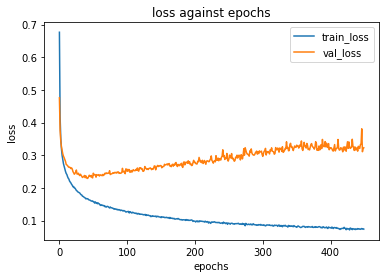

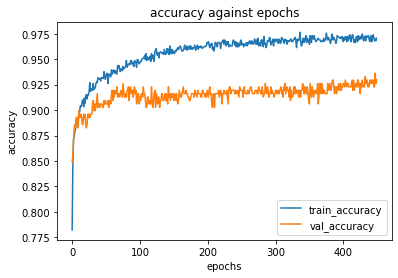

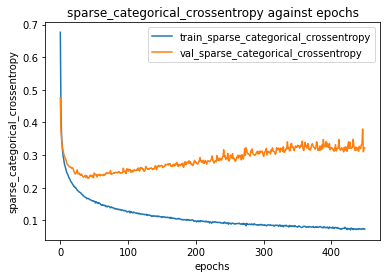

Model:  batch_size_4_fold_2


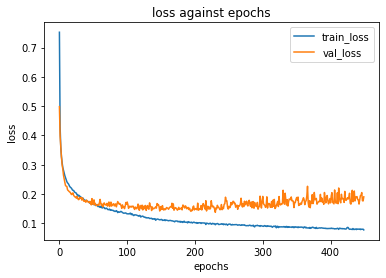

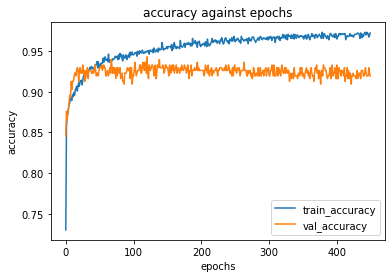

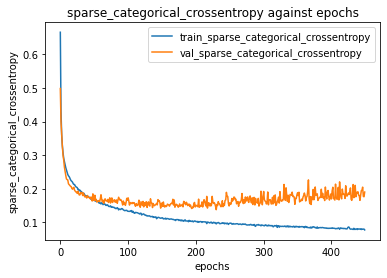

Model:  batch_size_4_fold_3


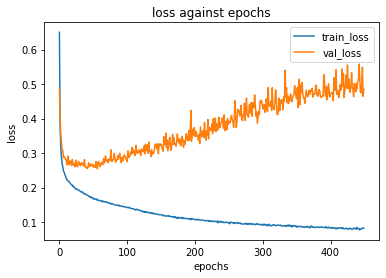

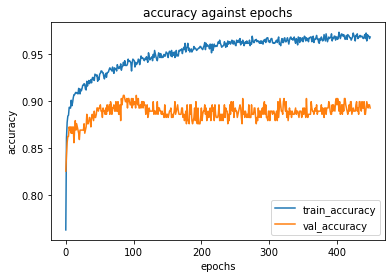

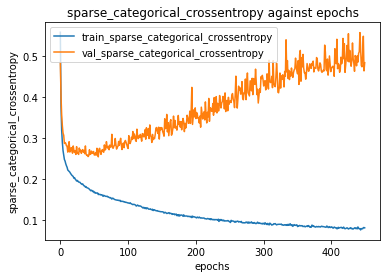

Model:  batch_size_4_fold_4


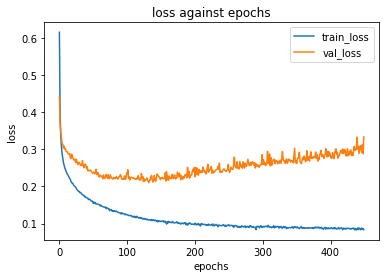

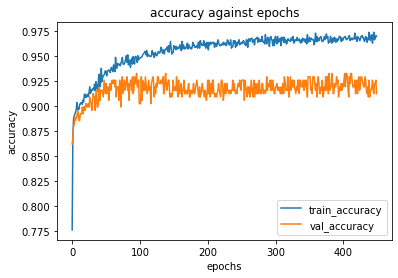

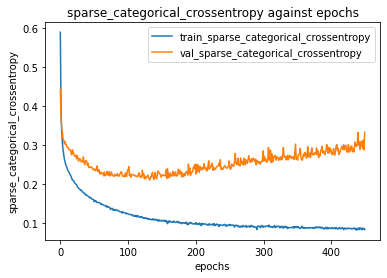

Model:  batch_size_4_fold_5


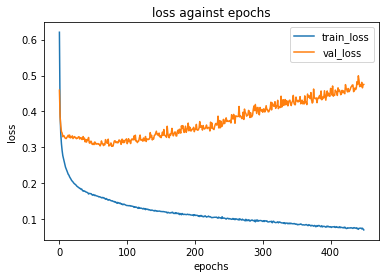

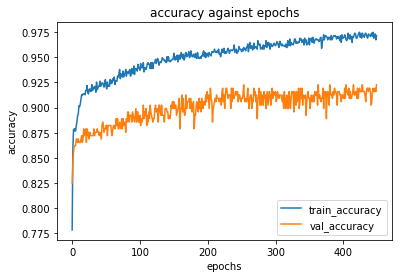

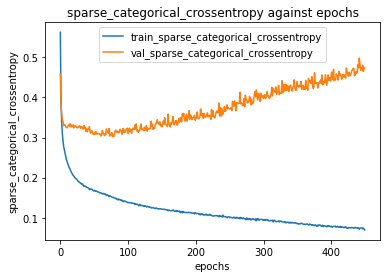

Model:  batch_size_8_fold_1


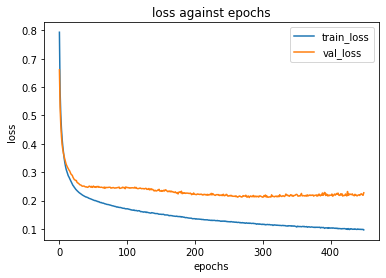

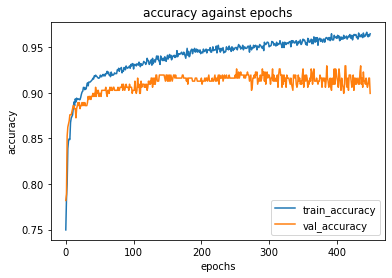

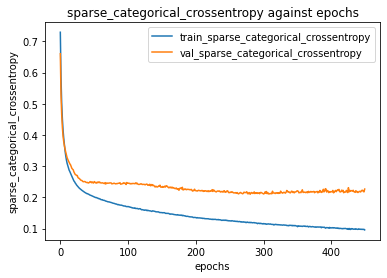

Model:  batch_size_8_fold_2


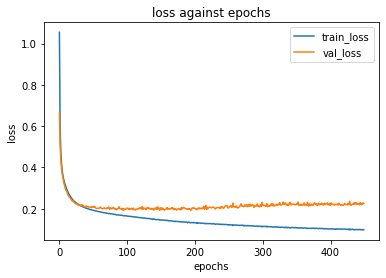

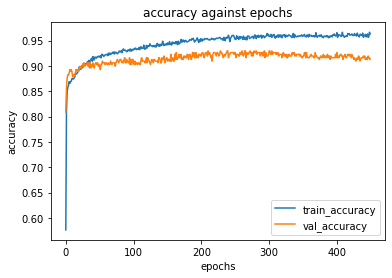

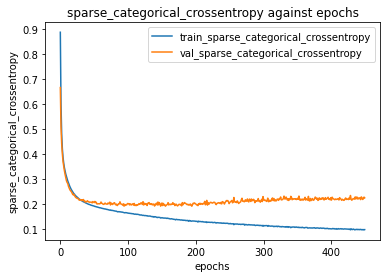

Model:  batch_size_8_fold_3


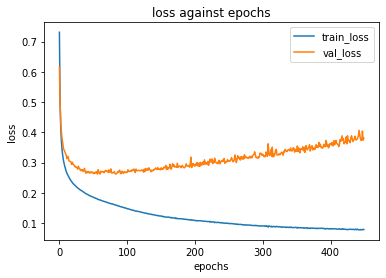

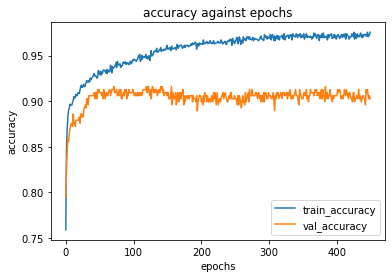

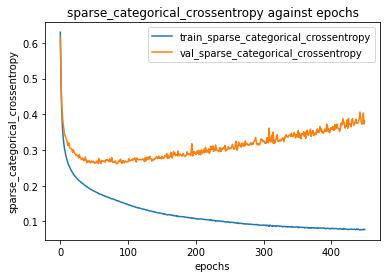

Model:  batch_size_8_fold_4


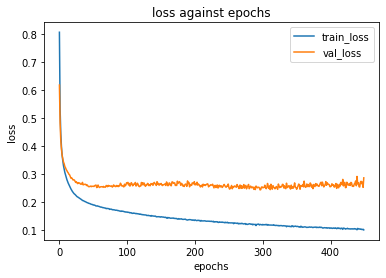

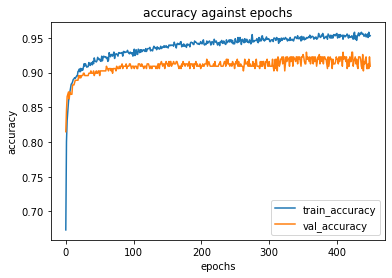

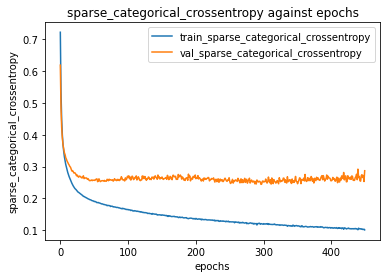

Model:  batch_size_8_fold_5


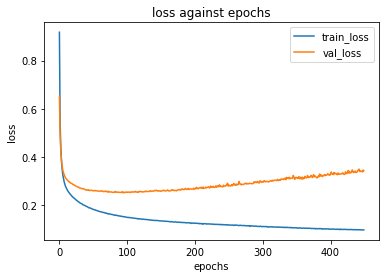

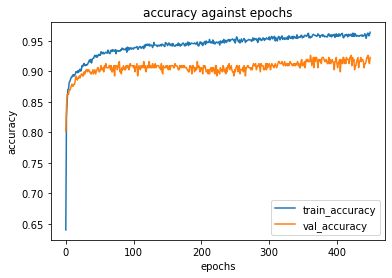

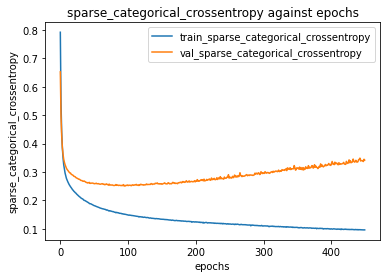

Model:  batch_size_16_fold_1


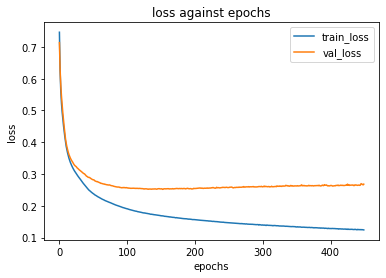

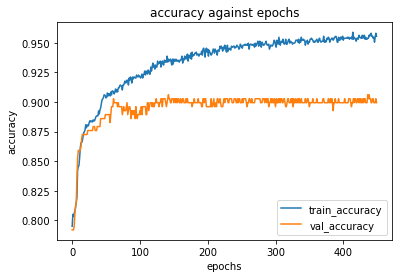

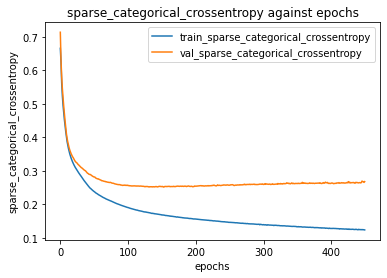

Model:  batch_size_16_fold_2


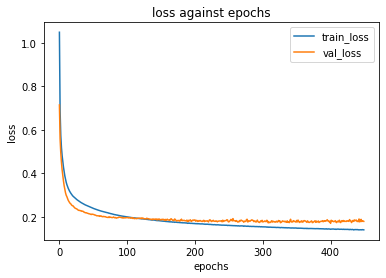

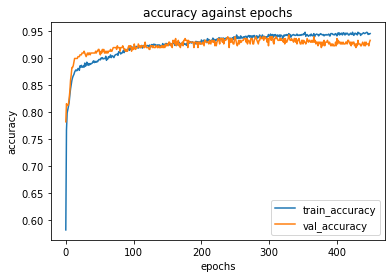

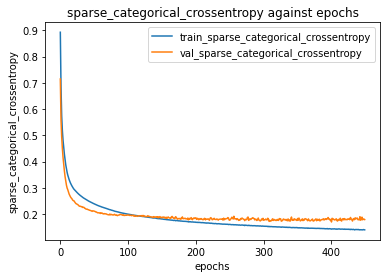

Model:  batch_size_16_fold_3


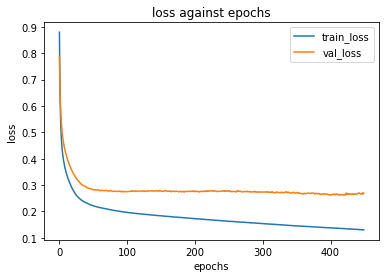

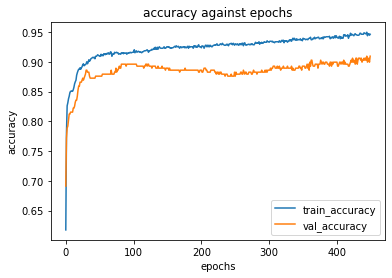

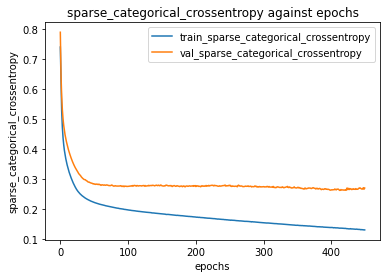

Model:  batch_size_16_fold_4


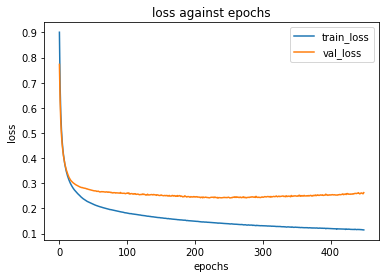

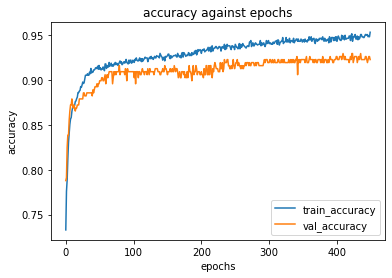

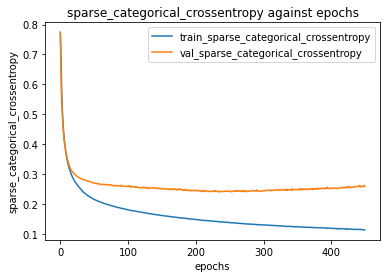

Model:  batch_size_16_fold_5


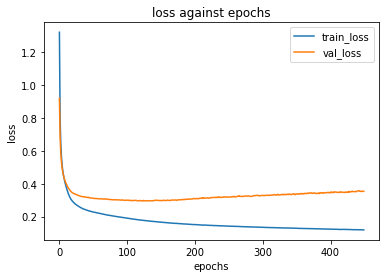

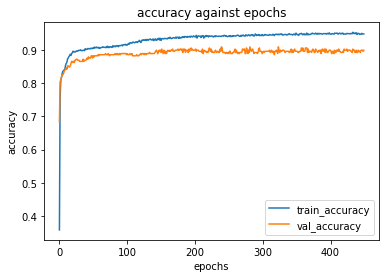

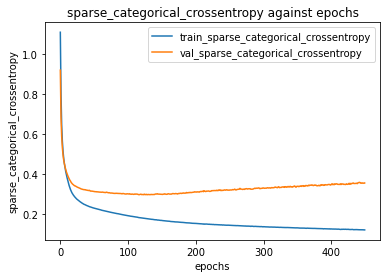

Model:  batch_size_32_fold_1


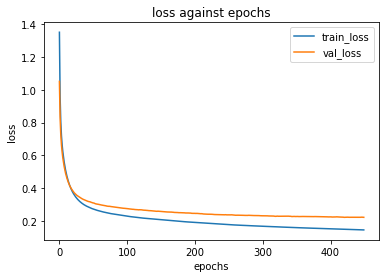

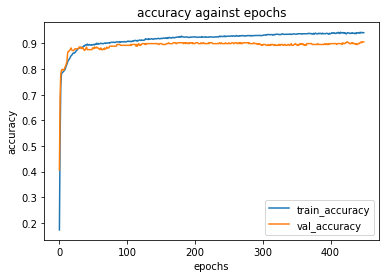

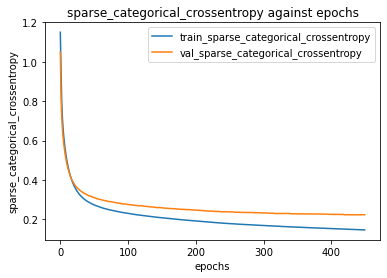

Model:  batch_size_32_fold_2


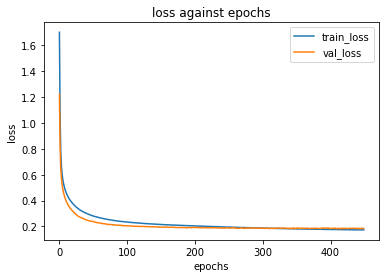

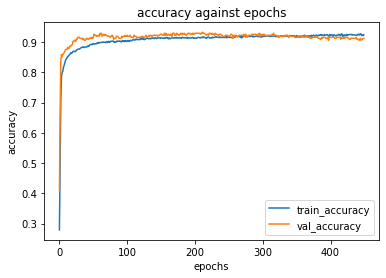

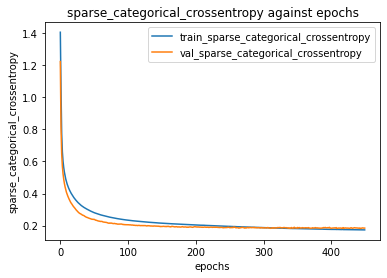

Model:  batch_size_32_fold_3


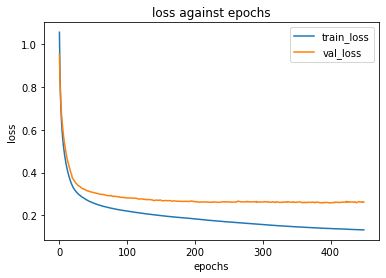

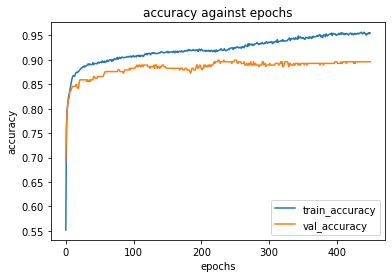

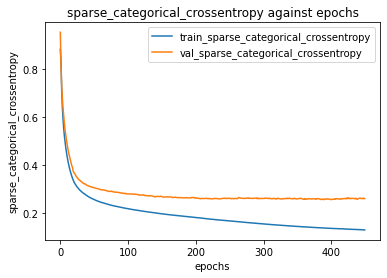

Model:  batch_size_32_fold_4


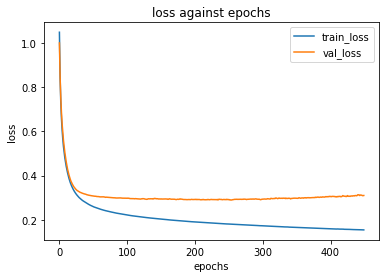

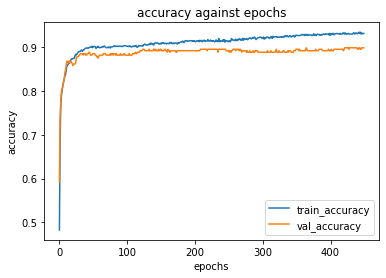

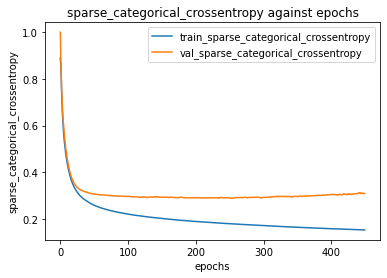

Model:  batch_size_32_fold_5


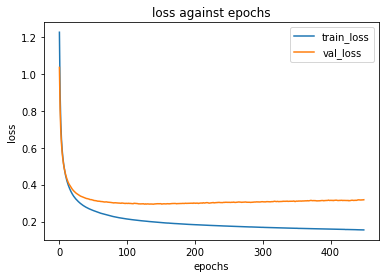

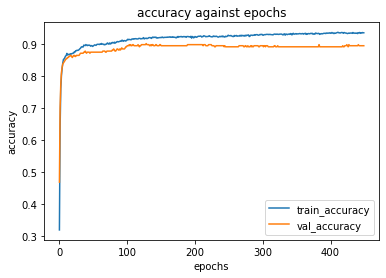

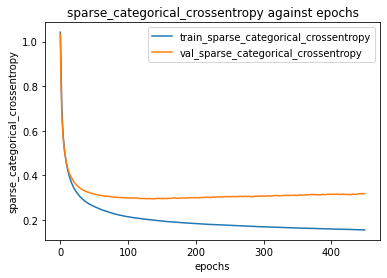

Model:  batch_size_64_fold_1


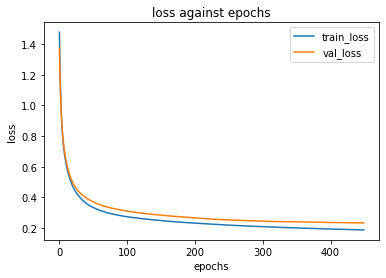

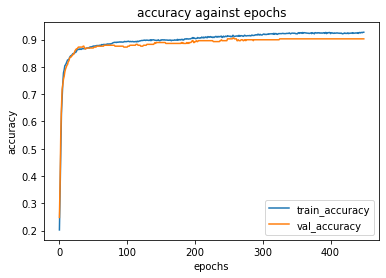

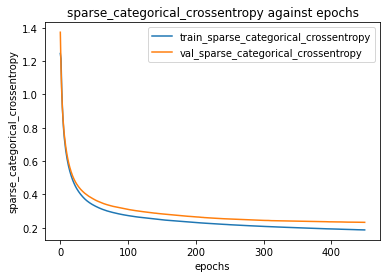

Model:  batch_size_64_fold_2


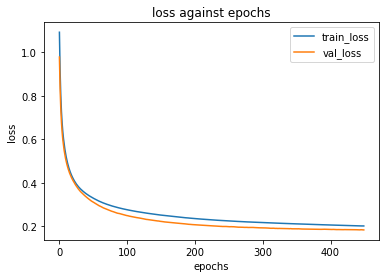

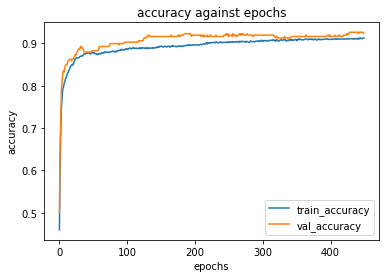

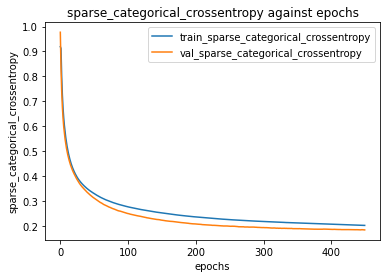

Model:  batch_size_64_fold_3


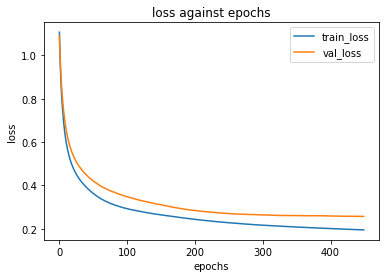

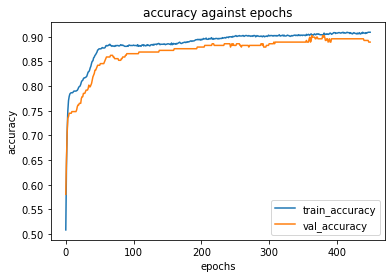

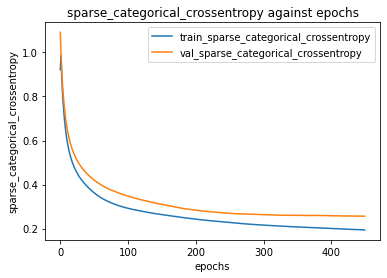

Model:  batch_size_64_fold_4


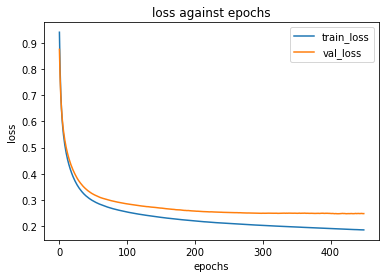

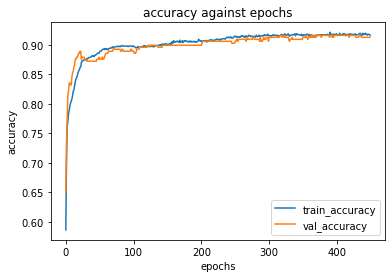

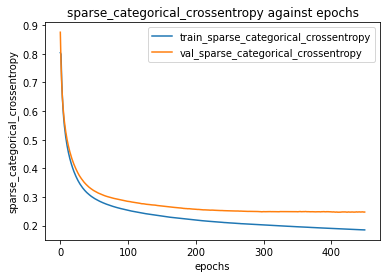

Model:  batch_size_64_fold_5


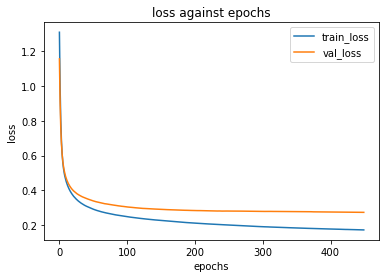

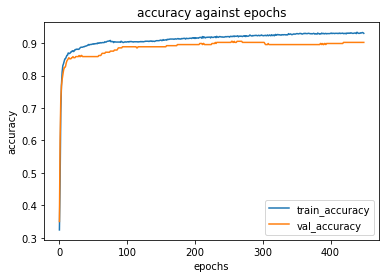

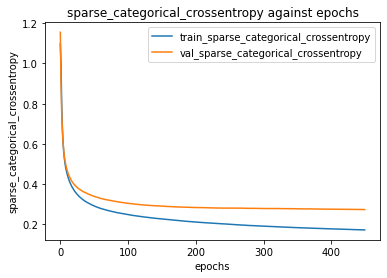

In [16]:
for model_name in histories.keys():
    print('Model: ', model_name)
    for history_object in ['loss', 'accuracy', 'sparse_categorical_crossentropy']:
        plot_history_object(histories, model_name, history_object)

### Comparing Models <a name="comparing_models"></a> 
[Back to top](#toc)

We will need two things for each batch, based on an average from all the five folds
1. Average time per epoch
2. Average accuracy/loss/sparse_categorical_crossentropy

> ### a) Plot cross-validation accuracies against the number of epochs for different batch sizes. Limit search space to batch sizes {4,8,16,32,64}. Plot the time taken to train the network for one epoch against different batch sizes.

##### Average Time per Epoch

In [17]:
ave_times = []
for batch_size in batch_sizes:
    total_time_batch = 0
    count = 0
    for index in range(5):
        batch_size_times = times['batch_size_' + str(batch_size) + '_fold_' + str(index+1)]
        total_time_batch += np.sum(batch_size_times)
        count += len(batch_size_times)
    ave_times.append(total_time_batch/count)

print("ave_times: ", ave_times)        

ave_times:  [0.20529628732469346, 0.11201943037245009, 0.06369873778025309, 0.040606344223022464, 0.03024602296617296]


Text(0.5, 1.0, 'batch_size vs ave_time (per epoch)')

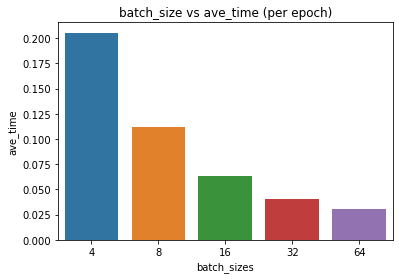

In [18]:
df_ave_times = pd.DataFrame(ave_times, columns =['ave_time']) 
df_batch_sizes = pd.DataFrame(batch_sizes, columns =['batch_sizes']) 
df_ave_times_batch_sizes = pd.concat([df_batch_sizes, df_ave_times], axis=1)

sns.barplot(data=df_ave_times_batch_sizes, x="batch_sizes", y="ave_time").set_title("batch_size vs ave_time (per epoch)")

##### Average Metrics per Epoch

In [19]:
ave_loss = []
ave_val_loss = []
ave_accuracy = []
ave_val_accuracy = []
ave_ce = []
ave_val_ce = []

for batch_size in batch_sizes:
    bs_loss = []
    bs_val_loss = []
    bs_accuracy = []
    bs_val_accuracy = []
    bs_ce = []
    bs_val_ce = []
    
    for index in range(5):
        history = histories['batch_size_' + str(batch_size) + '_fold_' + str(index+1)]

        bs_loss.append(np.array(history['loss']))
        bs_val_loss.append(np.array(history['val_loss']))
        bs_accuracy.append(np.array(history['accuracy']))
        bs_val_accuracy.append(np.array(history['val_accuracy']))
        bs_ce.append(np.array(history['sparse_categorical_crossentropy']))
        bs_val_ce.append(np.array(history['val_sparse_categorical_crossentropy']))
        
    ave_loss.append(np.mean(bs_loss, axis=0))
    ave_val_loss.append(np.mean(bs_val_loss, axis=0))
    ave_accuracy.append(np.mean(bs_accuracy, axis=0))
    ave_val_accuracy.append(np.mean(bs_val_accuracy, axis=0))
    ave_ce.append(np.mean(bs_ce, axis=0))
    ave_val_ce.append(np.mean(bs_val_ce, axis=0))

print('Generated averages')

Generated averages


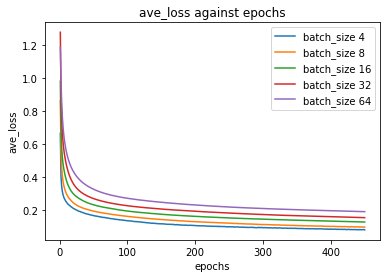

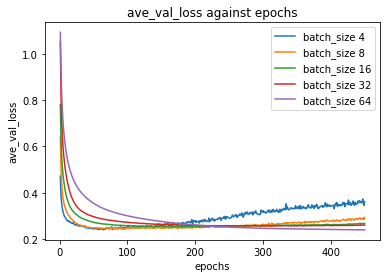

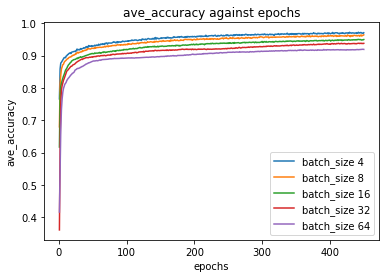

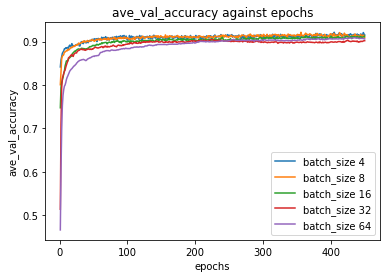

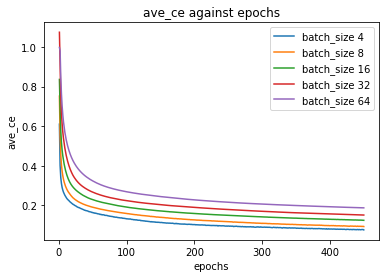

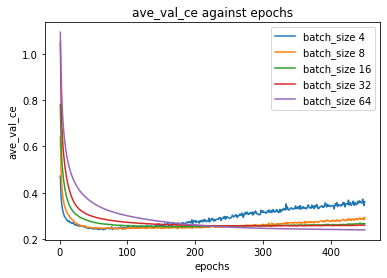

In [20]:
epochs_label = np.arange(1, epochs+1)

performance_metrics = [ave_loss, ave_val_loss, ave_accuracy, ave_val_accuracy, ave_ce, ave_val_ce]
performance_metrics_mapping = ['ave_loss', 'ave_val_loss', 'ave_accuracy', 'ave_val_accuracy', 'ave_ce', 'ave_val_ce']

for index, performance_metric in enumerate(performance_metrics):
    name = performance_metrics_mapping[index]
    
    for i in range(5):
        plt.plot(epochs_label, performance_metric[i], label='batch_size '+str(batch_sizes[i]))
        plt.title(name + " against epochs")
        plt.ylabel(name)
        plt.xlabel("epochs")
        plt.legend()
    plt.show()

### Eyeballing Batch Size <a name="eyeballing_batch_size"></a> 
[Back to top](#toc)

Generally, as batch size increases, we get increasingly worse performance, but faster training times.

We can see from averaging the validation set values, that ```batch_size=4,8``` performs the best early on, but their losses tend to diverge after more training cycles. 

On the other hand, ```batch_size=16,32,64``` are very stable, though they perform slightly worse than the smaller batch sizes. 

> ```batch_size=16``` appears to be an attractive target because it takes only a third of the time ```batch_size=4``` takes to run, but still offers comparable performance

Let's take a slightly more mathematical approach and consider the incremental time gains gotten from the incremental gains in performance, using our currently postulated ideal ```batch_size=16``` as the baseline

In [21]:
df_incremental_time = df_ave_times_batch_sizes.copy()
value = df_incremental_time['ave_time'][2]
df_incremental_time['ave_time'] = df_incremental_time['ave_time'] - value

df_incremental_time

,batch_sizes,ave_time
0,4,0.141598
1,8,0.048321
2,16,0.000000
3,32,-0.023092
4,64,-0.033453


In [22]:
incremental_ave_accuracy = np.array(ave_accuracy).T.copy()
incremental_ave_val_accuracy = np.array(ave_val_accuracy).T.copy()
incremental_ave_loss = np.array(ave_loss).T.copy()
incremental_ave_val_loss = np.array(ave_val_loss).T.copy()
incremental_ave_ce = np.array(ave_ce).T.copy()
incremental_ave_val_ce = np.array(ave_val_ce).T.copy()

In [23]:
incremental_metrics = [incremental_ave_accuracy, incremental_ave_val_accuracy, incremental_ave_loss, incremental_ave_val_loss, incremental_ave_ce, incremental_ave_val_ce]
incremental_metrics_mapping = ['incremental_ave_accuracy', 'incremental_ave_val_accuracy', 'incremental_ave_loss', 'incremental_ave_val_loss', 'incremental_ave_ce', 'incremental_ave_val_ce']

baseline_column = 'bs=16'

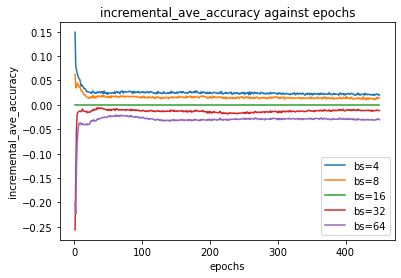

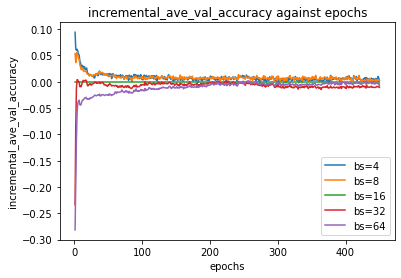

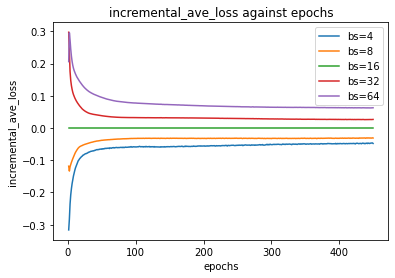

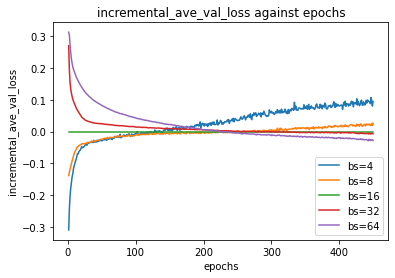

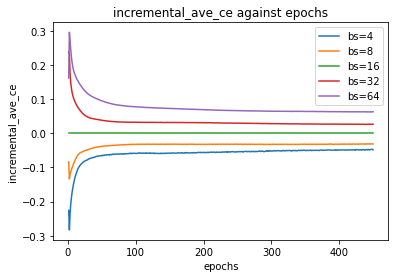

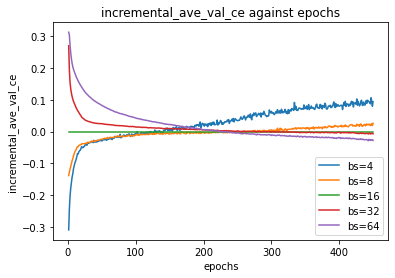

In [24]:
for index, incremental_metric in enumerate(incremental_metrics):
    df_incremental_metric = pd.DataFrame(incremental_metric, columns =['bs=4', 'bs=8', 'bs=16', 'bs=32', 'bs=64']) 
    df_incremental_metric_baseline = pd.DataFrame(df_incremental_metric[baseline_column], columns=[baseline_column])
    
    for column in df_incremental_metric.columns:
        df_incremental_metric[column] = df_incremental_metric[column] - df_incremental_metric_baseline[baseline_column]

    for column in df_incremental_metric.columns:
        plt.plot(epochs_label, df_incremental_metric[column], label=column)
        plt.title(incremental_metrics_mapping[index] + ' against epochs')
        plt.ylabel(incremental_metrics_mapping[index])
        plt.xlabel("epochs")
        plt.legend()    
    plt.show()

> ### b) Select the optimal batch size and state reasons for your selection. 

> ```batch_size=16``` is a good middle ground, and stable, and fast enough

It straddles the line well between incremental accuracy gained against larger batch sizes, and incremental fluctuations in losses gained against smaller batch sizes 

It also has a big advantage in time/epoch over smaller batch sizes, and comparable against larger batch sizes

```batch_size=32``` is a pretty good runner up, only worse in the accuracy department


### Try Test Set <a name="try_test_set"></a> 
[Back to top](#toc)

We shall use ```batch_size=16``` to check the performance of the model on the test set

In [25]:
def train_set_histories_objects(): 
    # the history object to keep performance of X_test Y_test from final model
    histories_test = {
        'test_values': {
            'loss': [],
            'accuracy': [],
            'sparse_categorical_crossentropy': []
        }
    }

    # the history object to keep performance of X_train Y_train from final model
    histories_model = {}
    
    return histories_test, histories_model

In [26]:
def train_set_histories_objects_save(histories_test, histories_model, histories_model_filename):
    histories_saver(histories_model, histories_model_filename)
    histories_model = histories_loader(histories_model_filename)

    histories_model['test_values'] = histories_test['test_values']

    histories_saver(histories_model, histories_model_filename, already_json=True)
    histories_model = histories_loader(histories_model_filename)
    
    return histories_model

In [27]:
histories_final = {}

In [28]:
# the parameter to be changed for the model
batch_size=16

model = create_model(num_neurons, num_classes, regularization, optimizer, loss, metrics)
histories_test, histories_model = train_set_histories_objects()


# create a new name and callback for every run
model_name = 'batch_size_test'
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test, Y_test)] 
histories_model_filename = "data/q2_histories_model_batch_size_test.json"

model_batch_size_test, histories_model['train_values'] = fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)


# save it and assign to histories_final
histories_final[model_name] = train_set_histories_objects_save(histories_test, histories_model, histories_model_filename)

Model created


Training  batch_size_test

Histories saved
Histories loaded
Histories saved
Histories loaded


> ### c) Plot the train and test accuracies against epochs for the optimal batch size. 

In [31]:
histories_saver(histories_final, "data/q2_histories_final.json", already_json=True)
histories_final = histories_loader("data/q2_histories_final.json")

Histories saved
Histories loaded


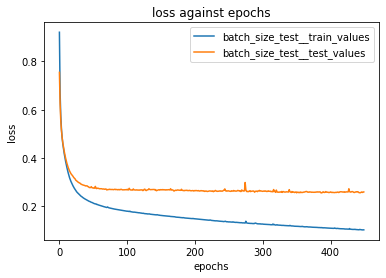

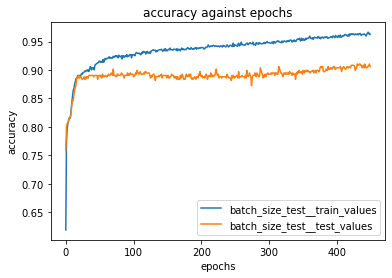

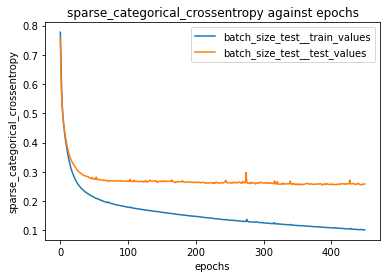

In [33]:
for history_object in ['loss', 'accuracy', 'sparse_categorical_crossentropy']:
    for model_name in histories_final.keys():
        for value_type in histories_final[model_name].keys():
            plt.plot(histories_final[model_name][value_type][history_object], label=model_name + '__' + value_type)

    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

# Conclusion <a name="conclusion"></a> 
[Back to top](#toc)

> ```batch_size=16``` appears to give the best value for incremental performance vs incremental time saved

It has the closest incremental performance to the best model which uses ```batch_size=4```, but has significant time savings per epoch, taking almost a third of the time 

> Select ```batch_size=16``` for future trainings